<a href="https://colab.research.google.com/github/ladyraga/Non-Linear-State-Estimation-/blob/main/Copy_of_Copy_of_Traj_Att_Quad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# Importing Libraries
from math import cos, sin
import numpy as np
#from CartPole import CartPole
from random import random
import scipy.signal as signal
import scipy.linalg as linalg
#from TrajectoryGenerator import TrajectoryGenerator
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [44]:
# Parameters
g = 9.806650  #gravity
m = 1.56  #mass
Jx = 0.114700 #moi wrt x
Jy = 0.057600 #moi wrt y
Jz = 0.171200 #moi wrt z
Ts = 0.05 # sampling time

'States'

# coordinates
pn = 0 #north
pe = 0 #east
pd = -2 #down

# velocities
u = 0 #wrt north
v = 0 #wrt east
w = 0 #wrt down

# angles
phi = 0   #roll
theta = 0 #pitch
psi = 0   #yaw

# angular rates
p = 0 #wrt roll
q = 0 #wrt pitch
r = 0 #wrt yaw

# initial states
states = np.array([pn, pe, pd, u, v, w, phi, theta, psi, p, q, r])

# Data collection for tragectories and plots
pn_data = []
pe_data = []
h_data = []
vn_data = []
ve_data = []
vd_data = []
phi_data = []
theta_data = []
psi_data = []
p_data = []
q_data = []
r_data = []
phi_c_data = []
theta_c_data = []
psi_t_data = []
r_c_data = []
pn_t_data = []
pe_t_data = []
pd_t_data = []
vn_t_data = []
ve_t_data = []
vd_t_data = []
err_pn = []
err_pe = []
err_pd = []
err_vn = []
err_ve = []
err_vd = []
err_psi = []
err_phi = []
err_theta = []
err_r = []

# simulation parameters
dt = Ts
Tfinal = 20
Tsteps = Tfinal/dt # number of frames
frames = int(Tsteps)

In [45]:
# A, B, Q, R, K matrix for attitude controller
A = np.array([[0, 1, 0, 0, 0],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0]])

B = np.array([[0, 0, 0],
              [1/Jx, 0, 0],
              [0, 0, 0],
              [0, 1/Jy, 0],
              [0, 0, 1/Jz]])

Q = np.array([[10, 0, 0, 0, 0],
              [0, 0.1, 0, 0, 0],
              [0, 0, 10, 0, 0],
              [0, 0, 0, 0.1, 0],
              [0, 0, 0, 0, 1]])

R1 = [[0.1, 0, 0],
      [0, 0.1, 0],
      [0, 0, 0.1]]

P = np.matrix(linalg.solve_continuous_are(A, B, Q, R1))
K = np.matrix(linalg.inv(R1)*(B.T*P))

eigVal, eigVec = linalg.eig(A-B*K)

# A, B, Q, R, K matrix for trajectory controller
A1 = np.array([[0, 0, 0, 1, 0, 0, 0],
               [0, 0, 0, 0, 1, 0, 0],
               [0, 0, 0, 0, 0, 1, 0],
               [0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0]])

B1 = np.array([[0, 0, 0, 0],
               [0, 0, 0, 0],
               [0, 0, 0, 0],
               [1, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, 0],
               [0, 0, 0, 1]])

Q1 = np.array([[10**3, 0, 0, 0, 0, 0, 0],
               [0, 10**3, 0, 0, 0, 0, 0],
               [0, 0, 10**3, 0, 0, 0, 0],
               [0, 0, 0, 10**2, 0, 0, 0],
               [0, 0, 0, 0, 10**2, 0, 0],
               [0, 0, 0, 0, 0, 50, 0],
               [0, 0, 0, 0, 0, 0, 10]])

R2 = np.array([[25, 0, 0, 0],
               [0, 25, 0, 0],
               [0, 0, 10, 0],
               [0, 0, 0, 10]])

P1 = np.matrix(linalg.solve_continuous_are(A1, B1, Q1, R2))
K1 = np.matrix(linalg.inv(R2)*(B1.T*P1))

eigVal1, eigVec1 = linalg.eig(A1-B1*K1)

In [46]:
# Rotational Matrix to convert body frame to inertial frame
def rot_mat_bod2veh(phi, theta, psi):
    R_b_v=np.array([[cos(theta)*cos(psi), sin(phi)*sin(theta)*cos(psi)-cos(phi)*sin(psi), cos(phi)*sin(theta)*cos(psi)+sin(phi)*sin(psi)],
                    [cos(theta)*sin(psi), sin(phi)*sin(theta)*sin(psi)+cos(phi)*cos(psi), cos(phi)*sin(theta)*sin(psi)-sin(phi)*cos(psi)],
                    [-sin(theta),         sin(phi)*cos(theta),                            cos(phi)*cos(theta)]])
    return R_b_v

In [47]:
# Matrix to orient ned to xyz
def axes_ned2yxz():
  A_ned = [[0, 1, 0],
           [1, 0, 0],
           [0, 0, -1]]
  return A_ned

In [48]:
# Matrix with relationship between derivatives of angles to angular rates
def der_ang2rates(phi, theta):
  sPh = np.sin(phi)
  cPh = np.cos(phi)
  sT = np.sin(theta)
  cT = np.cos(theta)
  TT = np.tan(theta)
  d_a_r = [[1, sPh*TT, cPh*TT],
           [0, cPh,    -sPh],
           [0, sPh/cT, cPh/cT]]
  return d_a_r

In [49]:
# Rotation matrix to eliminate psi
def psi_rot_mat(psi):
  cPs = np.cos(psi)
  sPs = np.sin(psi)
  R_psi = np.array([[cPs, sPs, 0],
                    [-sPs, cPs, 0],
                    [0, 0, 1]])
  return R_psi

In [50]:
# LQR controller for Attitude Control
def roll_lqr(y, y_c, K):
  u = -K[0,0]*(y[0]-y_c[0]) -K[0,1]*(y[1]-y_c[1]) -K[0,2]*(y[2]-y_c[2]) -K[0,3]*(y[3]-y_c[3]) -K[0,4]*(y[4]-y_c[4])
  return u

def pitch_lqr(y, y_c, K):
  u = -K[1,0]*(y[0]-y_c[0])-K[1,1]*(y[1]-y_c[1]) -K[1,2]*(y[2]-y_c[2]) -K[1,3]*(y[3]-y_c[3]) -K[1,4]*(y[4]-y_c[4])
  return u

def yaw_lqr(y, y_c, K):
  u = -K[2,0]*(y[0]-y_c[0]) -K[2,1]*(y[1]-y_c[1]) -K[2,2]*(y[2]-y_c[2]) -K[2,3]*(y[3]-y_c[3]) -K[2,4]*(y[4]-y_c[4])
  return u

In [51]:
# Function to generate reference trajectory and differential flatness
def trajectory (t):
  #case a
  a=1.5
  b=0.75
  c=0
  n=-0.75
  T=5
  w1=2*np.pi/T
  w2=w1/2
  w3=w1

  # #case b
  # a=1.5
  # b=0.75
  # c=0.5
  # n=-0.75
  # T=10
  # w1=2*np.pi/T
  # w2=w1/2
  # w3=w1
  
  # #case c
  # a=0.75
  # b=0.75
  # c=0
  # n=-0.75
  # T=10
  # w1=2*np.pi/T
  # w2=w1
  # w3=w1

  # #case d
  # a=1.5
  # b=a/2
  # c=b/2
  # n=-0.75
  # T=5*2
  # w1=2*np.pi/T
  # w2=w1/2
  # w3=w1/3
   
  ytraj=np.array([[a*cos(w2*t)], [b*sin(w1*t)], [n+c*sin(w3*t)], [np.pi/4]])
  ydottraj=np.array([[-a*w2*sin(w2*t)], [b*w1*cos(w1*t)], [c*w3*cos(w3*t)], [0]])
  yddottraj=np.array([[-a*w2*w2*cos(w2*t)], [-b*w1*w1*sin(w1*t)], [-c*w3*w3*sin(w3*t)], [0]])

  # ytraj=np.array([[a*signal.square(w2*t)], [b*signal.square(w1*t)], [n+c*sin(w3*t)], [np.pi/4]])
  # ydottraj=np.array([[-a*w2*sin(w2*t)], [b*w1*cos(w1*t)], [c*w3*cos(w3*t)], [0]])
  # yddottraj=np.array([[-a*w2*w2*cos(w2*t)], [-b*w1*w1*sin(w1*t)], [-c*w3*w3*sin(w3*t)], [0]])

  ur=np.array([yddottraj[0], yddottraj[1], yddottraj[2]-g, yddottraj[3]])   
  xr=np.array([ytraj[0], ytraj[1], ytraj[2], ydottraj[0], ydottraj[1], ydottraj[2], ytraj[3]])

  pn_t_data.append(a*cos(w2*t))
  pe_t_data.append(b*sin(w1*t))
  pd_t_data.append(-(n+c*sin(w3*t)))
  psi_t_data.append(np.pi/4)
  vn_t_data.append(-a*w2*sin(w2*t))
  ve_t_data.append(b*w1*cos(w1*t))
  vd_t_data.append(-c*w3*w3*sin(w3*t))

  return ur, xr

In [52]:
# LQR and Inverse mapping for trajectory control
def trajectory_control(states, xr, ur, K):
  pn = states[0]
  pe = states[1]
  pd = states[2]
  u = states[3]
  v = states[4]
  w = states[5]
  phi = states[6]
  theta = states[7]
  psi = states[8]
  p = states[9]
  q = states[10]
  r = states[11]

  x=np.array([[pn], [pe], [pd], [u], [v], [w], [psi]]) # 7 state system

  dx = x-xr # error from true to desired states
  du = -np.matmul(K1,dx)  # error input = -K*x (LQR)
  uc = du+ur  # reference input + error of input

  up = np.array([uc[0,0], uc[1,0], uc[2,0]])

  F = m*np.sqrt(np.matmul(up.transpose(), up))  # Thrust to input into dynamics

  R_psi = psi_rot_mat(psi)
  z = -np.matmul(R_psi, up)*m/F

  phi_c = np.arcsin(-z[1])  # commanded phi
  theta_c = np.arctan2(z[0], z[2])  # commanded theta
  r_c = uc[3,0]*cos(phi)*cos(theta)-q*sin(phi)  # commanded r

  # data collection for plotting errors in states
  err_pn.append(-dx[0])
  err_pe.append(-dx[1])
  err_pd.append(-dx[2])
  err_vn.append(-dx[3])
  err_ve.append(-dx[4])
  err_vd.append(-dx[5])
  err_psi.append(-dx[6])

  return F, float(phi_c), float(theta_c), float(r_c)

In [53]:
# Dynamics of the Quadrotor
def quad_dyna(t, y, F, T_phi, T_theta, T_psi):
  pn = y[0]
  pe = y[1]
  pd = y[2]
  u = y[3]
  v = y[4]
  w = y[5]
  phi = y[6]
  theta = y[7]
  psi = y[8]
  p = y[9]
  q = y[10]
  r = y[11]

  # x_dot of pned, ie velocities
  pn_dot = u
  pe_dot = v
  pd_dot = w
  
  # vel_dot, ie accelerations 
  R_b_w = rot_mat_bod2veh(phi,theta,psi)
  Thrust = np.array([0, 0, -F/m]).T
  gravity = np.array([0, 0, g]).T
  Accn = np.matmul(R_b_w, Thrust) + gravity
  
  u_dot = Accn[0]
  v_dot = Accn[1]
  w_dot = Accn[2]

  # angle_dot, ie angular rates
  Der = der_ang2rates(phi, theta)
  Ang_vel = np.matmul(Der, np.array([p,q,r]).T)
  
  phi_dot = Ang_vel[0]
  theta_dot = Ang_vel[1]
  psi_dot = Ang_vel[2]
  
  # angular rates_dot, ie angular accelerations
  Ang_accn = np.array([T_phi/Jx,T_theta/Jy,T_psi/Jz]).T + np.array([q*r*(Jy-Jz)/Jx,p*r*(Jz-Jx)/Jy,q*p*(Jx-Jy)/Jz]).T

  p_dot = Ang_accn[0]
  q_dot = Ang_accn[1]
  r_dot = Ang_accn[2]

  return pn_dot, pe_dot, pd_dot, u_dot, v_dot, w_dot, phi_dot, theta_dot, psi_dot, p_dot, q_dot, r_dot

In [54]:
# Solving the state space equation
def step(states, Ts, i):
  pn=states[0]
  pe=states[1]
  pd=states[2]
  u=states[3]
  v=states[4]
  w=states[5]
  phi=states[6]
  theta=states[7]
  psi=states[8]
  p=states[9]
  q=states[10]
  r=states[11]
  

  ur, xr = trajectory(i/15) # trajectory + diff flat

  F, phi_c, theta_c, r_c = trajectory_control(states, xr, ur, K)  # LQR + inv map

  y = np.array([phi, p, theta, q, r]) # states for attitude controller
  y_c = np.array([phi_c, 0, theta_c, 0, r_c]) # commanded states for attitude controller

  # Angular Inputs from LQR
  T_phi = roll_lqr(y, y_c, K)
  T_theta = pitch_lqr(y, y_c, K)
  T_psi = yaw_lqr(y, y_c, K)

  sol = solve_ivp(lambda t, y: quad_dyna(t, y, F, T_phi, T_theta, T_psi), [0, Ts], [ pn, pe, pd, u, v, w, phi, theta, psi,  p, q, r],   t_eval=np.linspace( 0, Ts, 10)  )
  states=sol.y[:,-1].T

  # Data collection for plots
  phi_c_data.append(phi_c)
  theta_c_data.append(theta_c)
  r_c_data.append(r_c)
  err_phi.append(y[0]-y_c[0])
  err_theta.append(y[1]-y_c[1])
  err_r.append(y[4]-y_c[4])

  return states

In [55]:
# function to draw the quad
def build_quad(pn, pe, pd, phi, theta, psi):
  pn = pn
  pe = pe
  pd = pd
  phi = phi
  theta = theta
  psi = psi
  
  # define width to use as reference to construct the quad 
  w = 0.75

  # defining the coordinates of the end points of the quad rotors
  p1 = np.array([w, 0, 0]).T
  p2 = np.array([-w, 0, 0]).T
  p3 = np.array([0, w, 0]).T
  p4 = np.array([0, -w, 0]).T

  # converting the quadrotor points to interial frame and translating as per ned
  R = rot_mat_bod2veh(phi, theta, psi) # rotational matrix
  pos_ned = np.array([pn, pe, pd]).T #
  p1r = np.matmul(R,p1)+pos_ned
  p2r = np.matmul(R,p2)+pos_ned
  p3r = np.matmul(R,p3)+pos_ned
  p4r = np.matmul(R,p4)+pos_ned

  # changing the orientation of ned wrt yxz
  A = axes_ned2yxz()
  p1ra = np.matmul(A,p1r)
  p2ra = np.matmul(A,p2r)
  p3ra = np.matmul(A,p3r)
  p4ra = np.matmul(A,p4r)

  # Rotor coordinates
  rot_x = [p1ra[0], p2ra[0], p3ra[0], p4ra[0]]
  rot_y = [p1ra[1], p2ra[1], p3ra[1], p4ra[1]]
  rot_z = [p1ra[2], p2ra[2], p3ra[2], p4ra[2]]

  # Arm coordinates
  arm1_x = [p1ra[0], p2ra[0]]
  arm1_y = [p1ra[1], p2ra[1]]
  arm1_z = [p1ra[2], p2ra[2]]

  arm2_x = [p3ra[0], p4ra[0]]
  arm2_y = [p3ra[1], p4ra[1]]
  arm2_z = [p3ra[2], p4ra[2]]

  # defining the coordinates of the payload
  v1 = np.array([-w/3,-w/3,w/2]).T
  v2 = np.array([-w/3,-w/3,0]).T
  v3 = np.array([w/3,-w/3,0]).T
  v4 = np.array([w/3,-w/3,w/2]).T
  v5 = np.array([w/3,w/3,w/2]).T
  v6 = np.array([w/3,w/3,0]).T
  v7 = np.array([-w/3,w/3,0]).T
  v8 = np.array([-w/3,w/3,w/2]).T

  # converting the payload points to interial frame and translating as per ned
  v1r = np.matmul(R,v1)+pos_ned
  v2r = np.matmul(R,v2)+pos_ned
  v3r = np.matmul(R,v3)+pos_ned
  v4r = np.matmul(R,v4)+pos_ned
  v5r = np.matmul(R,v5)+pos_ned
  v6r = np.matmul(R,v6)+pos_ned
  v7r = np.matmul(R,v7)+pos_ned
  v8r = np.matmul(R,v8)+pos_ned

  # changing the orientation of ned wrt yxz
  v1ra = np.matmul(A,v1r)
  v2ra = np.matmul(A,v2r)
  v3ra = np.matmul(A,v3r)
  v4ra = np.matmul(A,v4r)
  v5ra = np.matmul(A,v5r)
  v6ra = np.matmul(A,v6r)
  v7ra = np.matmul(A,v7r)
  v8ra = np.matmul(A,v8r)

  # defining the faces of the payload
  f1_x=[v1ra[0], v2ra[0], v3ra[0], v4ra[0], v1ra[0]]
  f1_y=[v1ra[1], v2ra[1], v3ra[1], v4ra[1], v1ra[1]]
  f1_z=[v1ra[2], v2ra[2], v3ra[2], v4ra[2], v1ra[2]]
  f2_x=[v5ra[0], v6ra[0], v7ra[0], v8ra[0], v5ra[0]]
  f2_y=[v5ra[1], v6ra[1], v7ra[1], v8ra[1], v5ra[1]]
  f2_z=[v5ra[2], v6ra[2], v7ra[2], v8ra[2], v5ra[2]]
  f3_x=[v4ra[0], v5ra[0], v6ra[0], v3ra[0], v4ra[0]]
  f3_y=[v4ra[1], v5ra[1], v6ra[1], v3ra[1], v4ra[1]]
  f3_z=[v4ra[2], v5ra[2], v6ra[2], v3ra[2], v4ra[2]]
  f4_x=[v1ra[0], v8ra[0], v7ra[0], v2ra[0], v1ra[0]]
  f4_y=[v1ra[1], v8ra[1], v7ra[1], v2ra[1], v1ra[1]]
  f4_z=[v1ra[2], v8ra[2], v7ra[2], v2ra[2], v1ra[2]]

  return rot_x, rot_y, rot_z, arm1_x, arm1_y, arm1_z, arm2_x, arm2_y, arm2_z, f1_x, f1_y, f1_z, f2_x, f2_y, f2_z, f3_x, f3_y, f3_z, f4_x, f4_y, f4_z

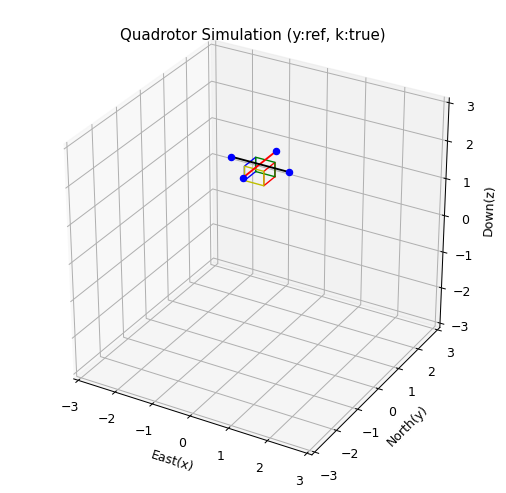

In [56]:
# Intial Plot
fig = plt.figure(figsize=(7,7), dpi=90)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlim((-3, 3))            
ax.set_ylim((-3, 3))
ax.set_zlim((-3, 3))
ax.set_xlabel('East(x)')
ax.set_ylabel('North(y)')
ax.set_zlabel('Down(z)')
ax.set_title('Quadrotor Simulation (y:ref, k:true)')

rot_x, rot_y, rot_z, arm1_x, arm1_y, arm1_z, arm2_x, arm2_y, arm2_z, f1_x, f1_y, f1_z, f2_x, f2_y, f2_z, f3_x, f3_y, f3_z, f4_x, f4_y, f4_z = build_quad(pn, pe, pd, phi, theta, psi)

# Collecting data for trajectories and plots
pn_data.append(states[0])
pe_data.append(states[1])
h_data.append(-states[2])
vn_data.append(states[3])
ve_data.append(states[4])
vd_data.append(states[5])
phi_data.append(states[6])
theta_data.append(states[7])
psi_data.append(states[8])
p_data.append(states[9])
q_data.append(states[10])
r_data.append(states[11])

# Creating handles for plotting and animation

# payload
face1, = ax.plot(f1_x, f1_y, f1_z, 'b', lw=1.1)
face2, = ax.plot(f2_x, f2_y, f2_z, 'r', lw=1.1)
face3, = ax.plot(f3_x, f3_y, f3_z, 'g', lw=1.1)
face4, = ax.plot(f4_x, f4_y, f4_z, 'y', lw=1.1)

# arms and rotors
arm1, = ax.plot(arm1_x, arm1_y, arm1_z, 'r-', lw=1.5)
arm2, = ax.plot(arm2_x, arm2_y, arm2_z, 'k-', lw=1.5)
rotor, = ax.plot(rot_x, rot_y, rot_z, 'bo', ms = 5)

# trajectory
traj, = ax.plot(pe_data, pn_data, h_data, 'y:', lw=1.5)
traj_ref, = ax.plot(pe_t_data, pn_t_data, pd_t_data, 'k-', lw=2)

In [57]:
# Function to update the points of the payload, arms and rotor coordinates
def drawframe(i):
  global states
  states = step(states, dt,i)
  pn = states[0]
  pe = states[1]
  pd = states[2]
  u = states[3]
  v = states[4]
  w = states[5]
  phi = states[6]
  theta = states[7]
  psi = states[8]
  p = states[9]
  q = states[10]
  r = states[11]

  rot_x, rot_y, rot_z, arm1_x, arm1_y, arm1_z, arm2_x, arm2_y, arm2_z, f1_x, f1_y, f1_z, f2_x, f2_y, f2_z, f3_x, f3_y, f3_z, f4_x, f4_y, f4_z = build_quad(pn, pe, pd, phi, theta, psi)

  pn_data.append(states[0])
  pe_data.append(states[1])
  h_data.append(-states[2])
  vn_data.append(states[3])
  ve_data.append(states[4])
  vd_data.append(states[5])
  phi_data.append(states[6])
  theta_data.append(states[7])
  psi_data.append(states[8])
  p_data.append(states[9])
  q_data.append(states[10])
  r_data.append(states[11])

  face1.set_data(f1_x, f1_y)
  face1.set_3d_properties(f1_z)
  face2.set_data(f2_x, f2_y)
  face2.set_3d_properties(f2_z)
  face3.set_data(f3_x, f3_y)
  face3.set_3d_properties(f3_z)
  face4.set_data(f4_x, f4_y)
  face4.set_3d_properties(f3_z)

  arm1.set_data(arm1_x, arm1_y)
  arm1.set_3d_properties(arm1_z)
  arm2.set_data(arm2_x, arm2_y)
  arm2.set_3d_properties(arm2_z)
  rotor.set_data(rot_x, rot_y)
  rotor.set_3d_properties(rot_z)

  traj.set_data(pe_data, pn_data)
  traj.set_3d_properties(h_data)

  traj_ref.set_data(pe_t_data, pn_t_data)
  traj_ref.set_3d_properties(pd_t_data)

  return face1, face2, face3, face4, arm1, arm2, rotor, traj, traj_ref

In [58]:
# Creating the Simulatiom
ax.set_xlabel('East(x)')
ax.set_ylabel('North(y)')
ax.set_zlabel('Down(z)')
ax.set_title('Quadrotor- LQR Controller to track a reference trajectory (y:ref, k:true)')
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=frames, interval=40, blit=True)

In [59]:
# Converting the animated result into a  html5 video for visualization
HTML(anim.to_html5_video())

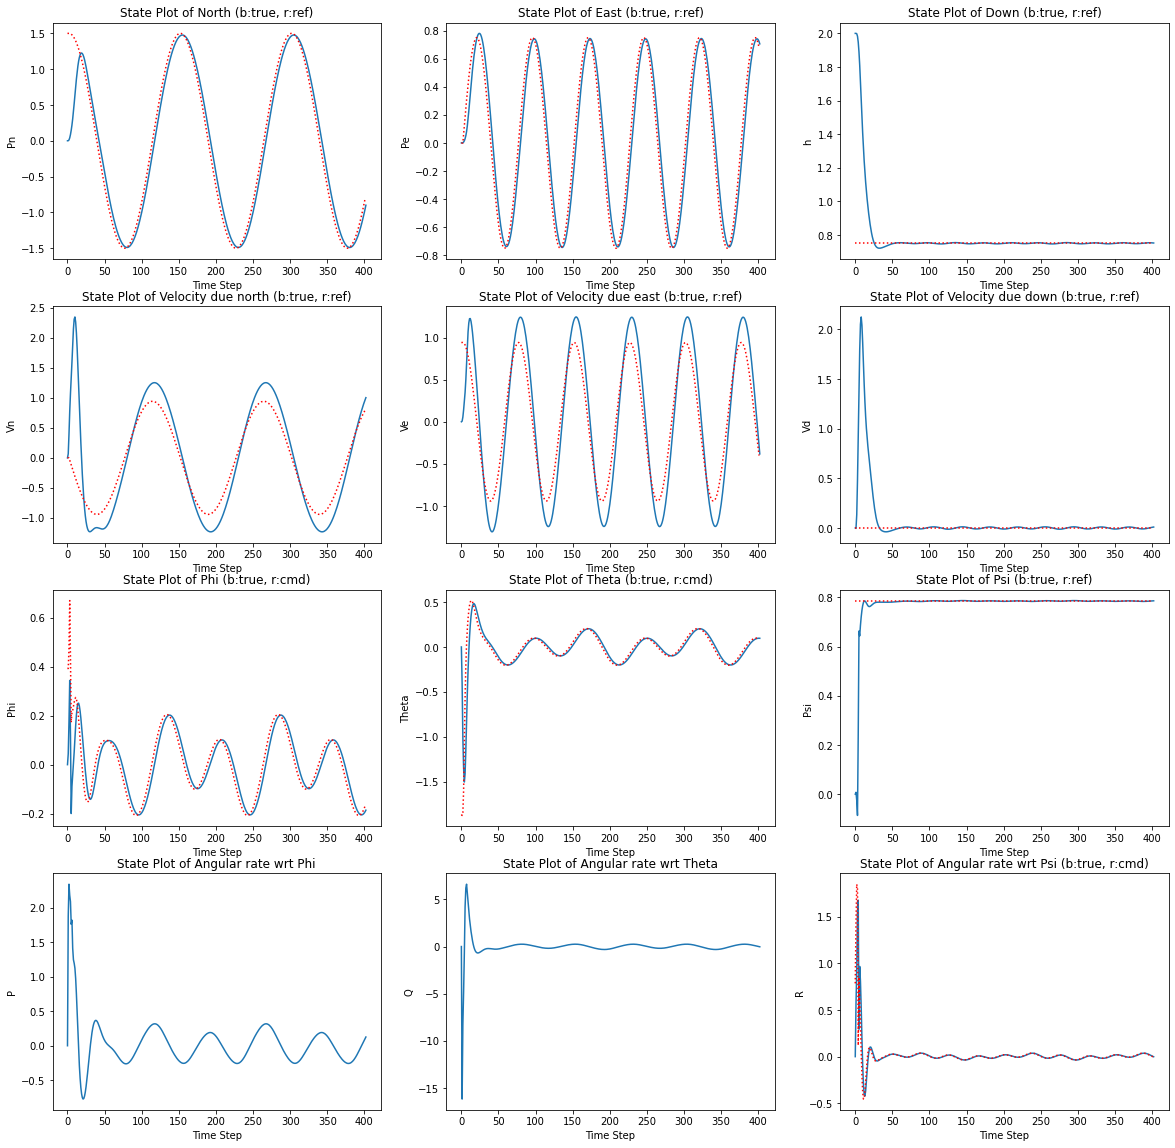

In [60]:
# Figure to plot the states against time step
fig1 = plt.figure(figsize=(20,20))
ax1 = fig1.add_subplot(4, 3, 1)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Pn')
ax1.set_title('State Plot of North (b:true, r:ref)')
pn1 = ax1.plot(range(len(pn_data)),pn_data)
pn_t1 = ax1.plot(range(len(pn_t_data)),pn_t_data,'r:')
ax2 = fig1.add_subplot(4, 3, 2)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Pe')
ax2.set_title('State Plot of East (b:true, r:ref)')
pe1 = ax2.plot(range(len(pe_data)),pe_data)
pe_t1 = ax2.plot(range(len(pe_t_data)),pe_t_data,'r:')
ax3 = fig1.add_subplot(4, 3, 3)
ax3.set_xlabel('Time Step')
ax3.set_ylabel('h')
ax3.set_title('State Plot of Down (b:true, r:ref)')
h1 = ax3.plot(range(len(h_data)),h_data)
pd_t1 = ax3.plot(range(len(pd_t_data)),pd_t_data,'r:')
ax4 = fig1.add_subplot(4, 3, 4)
ax4.set_xlabel('Time Step')
ax4.set_ylabel('Vn')
ax4.set_title('State Plot of Velocity due north (b:true, r:ref)')
vn1 = ax4.plot(range(len(vn_data)),vn_data)
vn_t1 = ax4.plot(range(len(vn_t_data)),vn_t_data,'r:')
ax5 = fig1.add_subplot(4, 3, 5)
ax5.set_xlabel('Time Step')
ax5.set_ylabel('Ve')
ax5.set_title('State Plot of Velocity due east (b:true, r:ref)')
ve1 = ax5.plot(range(len(ve_data)),ve_data)
ve_t1 = ax5.plot(range(len(ve_t_data)),ve_t_data,'r:')
ax6 = fig1.add_subplot(4, 3, 6)
ax6.set_xlabel('Time Step')
ax6.set_ylabel('Vd')
ax6.set_title('State Plot of Velocity due down (b:true, r:ref)')
vd1 = ax6.plot(range(len(vd_data)),vd_data)
ve_t1 = ax6.plot(range(len(vd_t_data)),vd_t_data,'r:')
ax7 = fig1.add_subplot(4, 3, 7)
ax7.set_xlabel('Time Step')
ax7.set_ylabel('Phi')
ax7.set_title('State Plot of Phi (b:true, r:cmd)')
phi1 = ax7.plot(range(len(phi_data)),phi_data)
phi_c1 = ax7.plot(range(len(phi_c_data)),phi_c_data,'r:')
ax8 = fig1.add_subplot(4, 3, 8)
ax8.set_xlabel('Time Step')
ax8.set_ylabel('Theta')
ax8.set_title('State Plot of Theta (b:true, r:cmd)')
theta1 = ax8.plot(range(len(theta_data)),theta_data)
theta_c1 = ax8.plot(range(len(theta_c_data)),theta_c_data,'r:')
ax9 = fig1.add_subplot(4, 3, 9)
ax9.set_xlabel('Time Step')
ax9.set_ylabel('Psi')
ax9.set_title('State Plot of Psi (b:true, r:ref)')
psi1 = ax9.plot(range(len(psi_data)),psi_data)  
psi_t1 = ax9.plot(range(len(psi_t_data)),psi_t_data,'r:')
ax10 = fig1.add_subplot(4, 3, 10)
ax10.set_xlabel('Time Step')
ax10.set_ylabel('P')
ax10.set_title('State Plot of Angular rate wrt Phi')
p1 = ax10.plot(range(len(p_data)),p_data)
ax11 = fig1.add_subplot(4, 3, 11)
ax11.set_xlabel('Time Step')
ax11.set_ylabel('Q')
ax11.set_title('State Plot of Angular rate wrt Theta')
q1 = ax11.plot(range(len(q_data)),q_data)
ax12 = fig1.add_subplot(4, 3, 12)
ax12.set_xlabel('Time Step')
ax12.set_ylabel('R')
ax12.set_title('State Plot of Angular rate wrt Psi (b:true, r:cmd)')
r1 = ax12.plot(range(len(r_data)),r_data)
r_c1 = ax12.plot(range(len(r_c_data)),r_c_data,'r:')

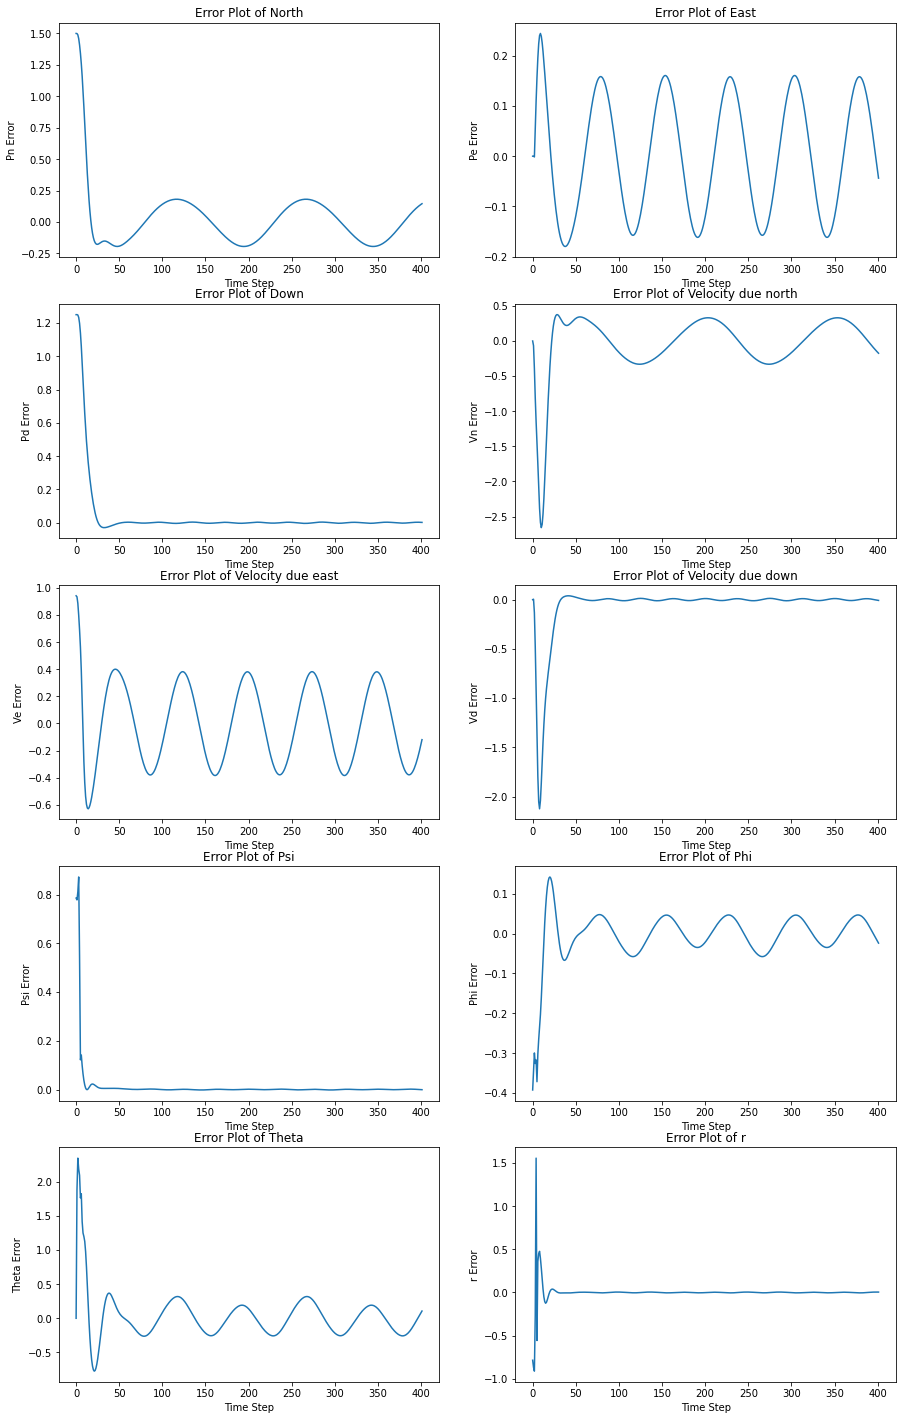

In [61]:
# Figure to plot the states erros against time step
fig2 = plt.figure(figsize=(15,25))
ax1 = fig2.add_subplot(5, 2, 1)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Pn Error')
ax1.set_title('Error Plot of North')
pn1 = ax1.plot(range(len(err_pn)),err_pn)
ax2 = fig2.add_subplot(5, 2, 2)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Pe Error')
ax2.set_title('Error Plot of East')
pe1 = ax2.plot(range(len(err_pe)),err_pe)
ax3 = fig2.add_subplot(5, 2, 3)
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Pd Error')
ax3.set_title('Error Plot of Down')
h1 = ax3.plot(range(len(err_pd)),err_pd)
ax4 = fig2.add_subplot(5, 2, 4)
ax4.set_xlabel('Time Step')
ax4.set_ylabel('Vn Error')
ax4.set_title('Error Plot of Velocity due north')
vn1 = ax4.plot(range(len(err_vn)),err_vn)
ax5 = fig2.add_subplot(5, 2, 5)
ax5.set_xlabel('Time Step')
ax5.set_ylabel('Ve Error')
ax5.set_title('Error Plot of Velocity due east')
ve1 = ax5.plot(range(len(err_ve)),err_ve)
ax6 = fig2.add_subplot(5, 2, 6)
ax6.set_xlabel('Time Step')
ax6.set_ylabel('Vd Error')
ax6.set_title('Error Plot of Velocity due down')
vd1 = ax6.plot(range(len(err_vd)),err_vd)
ax7 = fig2.add_subplot(5, 2, 7)
ax7.set_xlabel('Time Step')
ax7.set_ylabel('Psi Error')
ax7.set_title('Error Plot of Psi')
psi1 = ax7.plot(range(len(err_psi)),err_psi)
ax8 = fig2.add_subplot(5, 2, 8)
ax8.set_xlabel('Time Step')
ax8.set_ylabel('Phi Error')
ax8.set_title('Error Plot of Phi')
phi1 = ax8.plot(range(len(err_phi)),err_phi)
ax9 = fig2.add_subplot(5, 2, 9)
ax9.set_xlabel('Time Step')
ax9.set_ylabel('Theta Error')
ax9.set_title('Error Plot of Theta')
theta1 = ax9.plot(range(len(err_theta)),err_theta)
ax10 = fig2.add_subplot(5, 2, 10)
ax10.set_xlabel('Time Step')
ax10.set_ylabel('r Error')
ax10.set_title('Error Plot of r')
r1 = ax10.plot(range(len(err_r)),err_r)